In [8]:
# Import libraries and set desired options
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy import sparse, stats
from scipy.linalg import svd
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     cross_validate, train_test_split)
from tqdm import tqdm
from xgboost import XGBClassifier

In [9]:
TRAIN_PATH = 'data/train/'

# Read data sets

In [10]:
X1 = pd.read_csv(TRAIN_PATH + 'X1.csv')
X2 = pd.read_csv(TRAIN_PATH + 'X2.csv')
X3 = pd.read_csv(TRAIN_PATH + 'X3.csv')

Y = pd.read_csv(TRAIN_PATH + 'Y.csv')

FileNotFoundError: [Errno 2] File b'data/train/X1.csv' does not exist: b'data/train/X1.csv'

In [4]:
TEST_PATH = 'test/'

In [5]:
X1_test = pd.read_csv(TEST_PATH + 'X1.csv')
X2_test = pd.read_csv(TEST_PATH + 'X2.csv')
X3_test = pd.read_csv(TEST_PATH + 'X3.csv')

In [6]:
# X3.to_csv(DATA_PATH + 'X3.csv', index=None)

In [7]:
Y.head()

,id,1,2,3,4,5
0,3,1,1,0,0,1
1,5,0,1,0,0,0
2,6,0,1,0,0,0
3,8,1,0,0,0,0
4,10,0,0,1,1,0


## Transform X2 using SVD

In [8]:
def transform_x2(X2, svd=None):
    rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
    cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)
    sparse_matrix = np.zeros((len(rows), len(cols)))

    sparse_matrix[row_pos, col_pos] = 1

    cols_ = sparse_matrix.sum(axis=0)
    rows_ = sparse_matrix.sum(axis=1)

    minimum_users_per_group = 5
    selected_cols = cols_ >= minimum_users_per_group
    trimmed_sparse_matrix = sparse_matrix[:, selected_cols]

    sns.distplot(trimmed_sparse_matrix.sum(axis=0), bins=100)

    if svd is None:
        svd = TruncatedSVD(n_components=150)
        svd.fit(trimmed_sparse_matrix)

    components = pd.DataFrame(svd.transform(trimmed_sparse_matrix))
    components['id'] = X2.iloc[:, 0].unique()
    X2 = components
    return X2, svd

## Merge all datasets into one

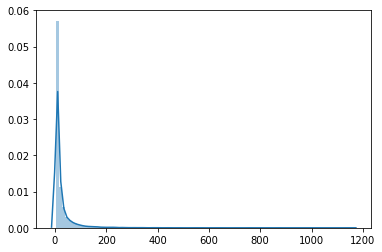

In [9]:
X2_all = X2.append(X2_test)
X2_all, svd = transform_x2(X2_all)

In [10]:
X2 = X2_all[X2_all.id.isin(X1.id)]
df = X1.merge(X2, on='id', how='inner').merge(X3, on='id').merge(Y, on='id')
X = df.iloc[:, :-5]
Y_cls = df.iloc[:, -5:]

In [11]:
X2_test = X2_all[X2_all.id.isin(X1_test.id)]
df_test = X1_test.merge(X2_test, on='id', how='inner').merge(X3_test, on='id')
X_test = df_test

# Modeling

In [12]:
def cross_validation_score_statement(estimator,
                                     X,
                                     y,
                                     scoring,
                                     n_splits=5,
                                     statement=None,
                                     random_state=0):
    """
    Evaluate a score by cross-validation. 
    The fit method will be performed on the entire train subset at each iteration,
    the predict method and scoring will be performed only for objects from test subset where statement is True
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit' and 'predict'
        The object to use to fit the data.
    X : pandas.DataFrame
        The data to fit.
    y : pandas.Series
        The target variable to try to predict.
    scoring : callable 
        The scoring function of signature scoring(y_true,y_pred).
    statement : boolean numpy.array of shape equal to y.shape
        The mask showing the objects we want to evaluate estimator on.
    n_splits : int
        Number of folds for cross-validation
    random_state : int
        Random_state for KFold and StratifiedKFold    
    
    Returns
    -----------
    scores : array of float, shape=(n_splits,)
    
    """
    if statement is None:
        cv = KFold(n_splits=n_splits, shuffle=False, random_state=random_state)
        cv_iter = list(cv.split(X, y))
    else:
        cv = StratifiedKFold(n_splits=n_splits,
                             shuffle=True,
                             random_state=random_state)
        cv_iter = list(cv.split(X, statement))
    scores = []

    for train, test in cv_iter:
        estimator.fit(X.iloc[train, :].values, y.iloc[train].values)
        if statement is not None:
            y_statement = y.iloc[test].loc[statement[test]]
            pred_statement = estimator.predict_proba(
                X.iloc[test, :].loc[statement[test]].values)[:, 1]
        else:
            y_statement = y.iloc[test]
            pred_statement = estimator.predict_proba(X.iloc[test, :].values)[:, 1]
        scores.append(scoring(y_statement, pred_statement))
    return np.array(scores)

In [13]:
params = {'1': {'alpha': 0,
  'colsample_bytree': 0.6,
  'eta': 0.05,
  'learning_rate': 0.017,
  'max_delta_step': 5,
  'max_depth': 2,
  'min_child_samples': 100,
  'min_child_weight': 5,
  'n_estimators': 200,
  'num_leaves': 44,
  'scale_pos_weight': 1},
 '2': {'alpha': 1,
  'colsample_bytree': 0.75,
  'eta': 0.225,
  'learning_rate': 0.033,
  'max_delta_step': 9,
  'max_depth': 1,
  'min_child_samples': 100,
  'min_child_weight': 2,
  'n_estimators': 200,
  'num_leaves': 19,
  'scale_pos_weight': 0.75},
 '3': {'alpha': 0,
  'colsample_bytree': 0.75,
  'eta': 0.21,
  'learning_rate': 0.019,
  'max_delta_step': 3,
  'max_depth': 3,
  'min_child_samples': 150,
  'min_child_weight': 4,
  'n_estimators': 675,
  'num_leaves': 10,
  'scale_pos_weight': 0.75},
 '4': {'alpha': 1,
  'colsample_bytree': 0.9,
  'eta': 0.39,
  'learning_rate': 0.021,
  'max_delta_step': 5,
  'max_depth': 1,
  'min_child_samples': 150,
  'min_child_weight': 7,
  'n_estimators': 325,
  'num_leaves': 20,
  'scale_pos_weight': 0.75},
 '5': {'alpha': 1,
  'colsample_bytree': 0.7,
  'eta': 0.08,
  'learning_rate': 0.03,
  'max_delta_step': 9,
  'max_depth': 1,
  'min_child_samples': 50,
  'min_child_weight': 10,
  'n_estimators': 225,
  'num_leaves': 20,
  'scale_pos_weight': 0.75}}

In [15]:
models = []
probas = []
scores = []
for i in tqdm('12345'):
    cls = XGBClassifier(n_jobs=8, random_state=0, **params[i])
    cls.fit(X.values, Y_cls[i].values)
    proba = cls.predict_proba(X_test.values)[:, 1]
    probas += [proba]
    models.append(cls)


100%|██████████| 5/5 [02:28<00:00, 26.43s/it]


In [16]:
tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('baseline.csv', index=False)